In [9]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from DataGenerator import generateOneClusterData
from Settings import (DEFAULT_NUMBER_OF_FEATURES,
                        DEFAULT_NUMBER_OF_RECORDS_PER_CLASS,
                        DEFAULT_FEATURE_MEAN_RANGE,
                        DEFAULT_RANDOM_NUMBER_SEED)

data = generateOneClusterData(DEFAULT_NUMBER_OF_FEATURES,
                            DEFAULT_NUMBER_OF_RECORDS_PER_CLASS,
                            DEFAULT_FEATURE_MEAN_RANGE, 
                            DEFAULT_RANDOM_NUMBER_SEED, distribution="uniform")

data_gaussian = generateOneClusterData(DEFAULT_NUMBER_OF_FEATURES,
                            DEFAULT_NUMBER_OF_RECORDS_PER_CLASS,
                            DEFAULT_FEATURE_MEAN_RANGE, 
                            DEFAULT_RANDOM_NUMBER_SEED)

rcParams['figure.figsize'] = (8.0, 8.0)
from gap_statistic import OptimalK
optimalK = OptimalK(parallel_backend='joblib')

cluster_point_size = 3

perplexity_range = [1,30, 100, 200, 300]
cluster_arr = range(1,50)

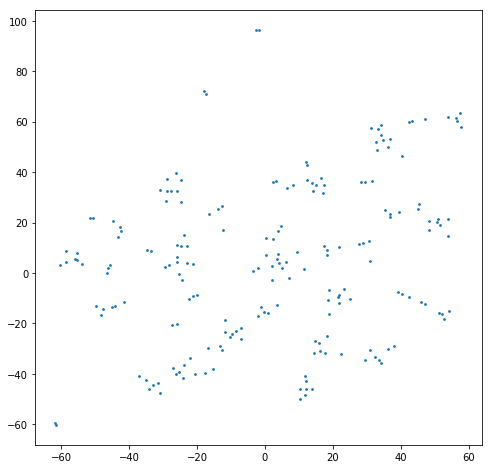

Perplexity: 1, Optimal K: 44


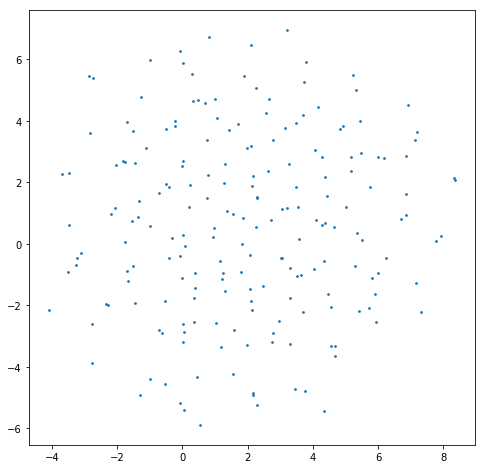

Perplexity: 30, Optimal K: 1


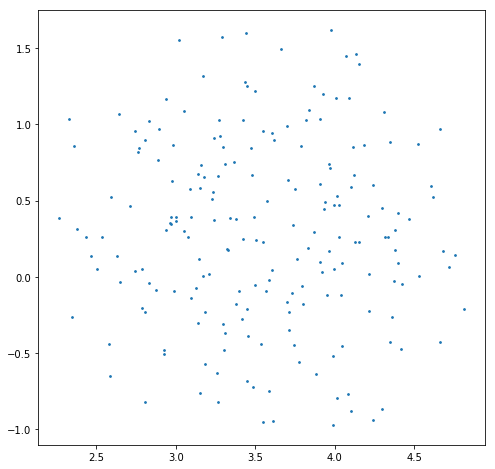

Perplexity: 100, Optimal K: 1


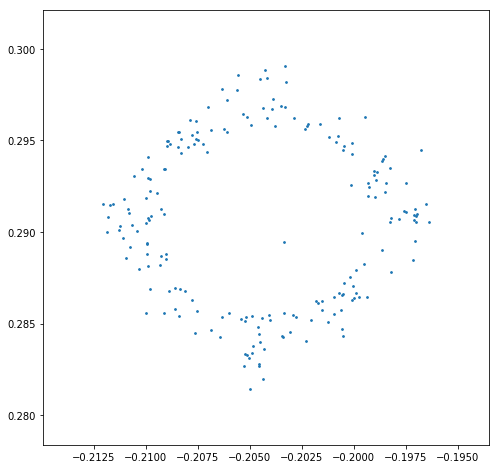

Perplexity: 200, Optimal K: 24


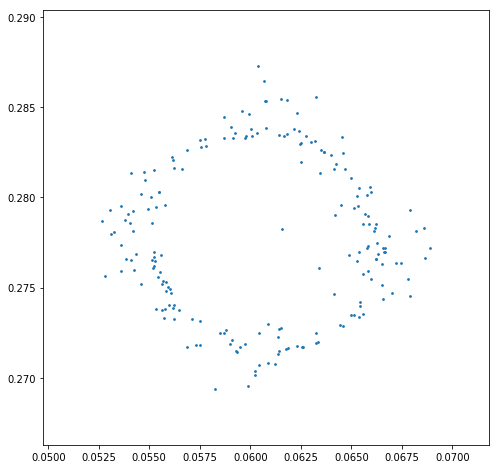

Perplexity: 300, Optimal K: 47


In [2]:
for p in perplexity_range:
    X_embedded = TSNE(n_components=2, perplexity=p).fit_transform(data)
    X_embedded.shape
    data.shape
    plt.scatter(X_embedded[:,0], X_embedded[:,1], s=cluster_point_size)
    plt.show()

    optK = optimalK(X_embedded, cluster_array=cluster_arr, n_refs=3)
    print("Perplexity: {}, Optimal K: {}".format(p, optK))

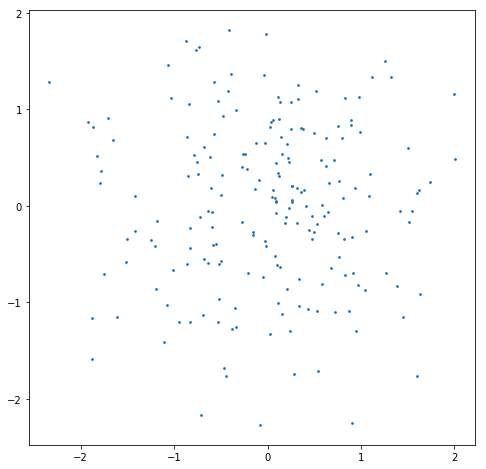

Optimal K: 1


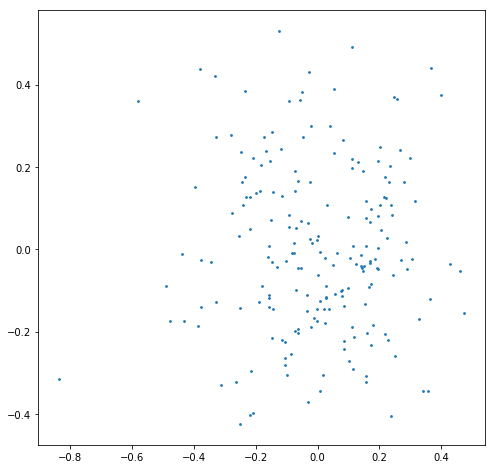

Optimal K: 1


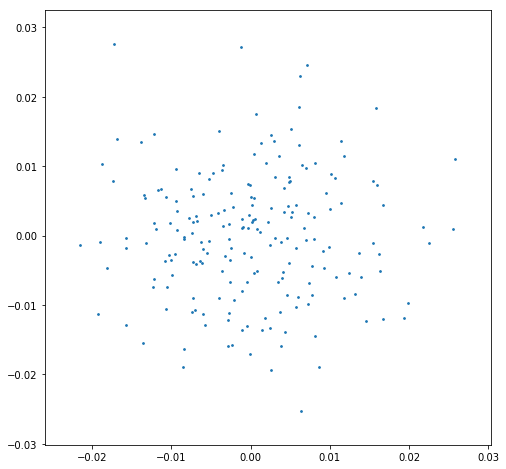

Optimal K: 1


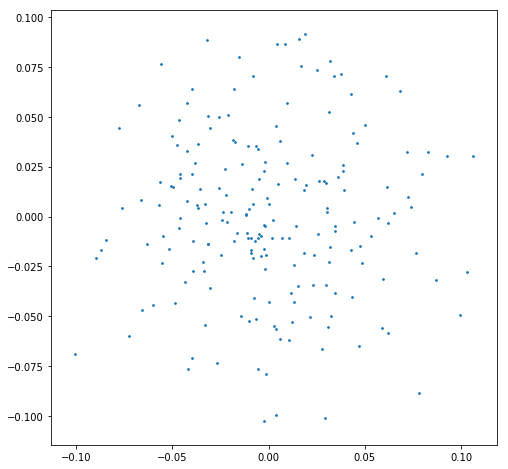

Optimal K: 1


In [3]:
X_kernel_pca = KernelPCA(n_components=2).fit_transform(data)
plt.scatter(X_kernel_pca[:,0], X_kernel_pca[:,1], s=cluster_point_size)
plt.show()
optK = optimalK(X_kernel_pca, cluster_array=cluster_arr, n_refs=3)
print("Optimal K: {}".format(optK))


X_kernel_pca_poly = KernelPCA(n_components=2, kernel="poly").fit_transform(data)
plt.scatter(X_kernel_pca_poly[:,0],  X_kernel_pca_poly[:,1], s=cluster_point_size)
plt.show()
optK = optimalK(X_kernel_pca_poly, cluster_array=cluster_arr, n_refs=3)
print("Optimal K: {}".format(optK))


X_kernel_pca_sigmoid = KernelPCA(n_components=2, kernel="sigmoid").fit_transform(data)
plt.scatter(X_kernel_pca_sigmoid[:,0],  X_kernel_pca_sigmoid[:,1], s=cluster_point_size)
plt.show()
optK = optimalK(X_kernel_pca_sigmoid, cluster_array=cluster_arr, n_refs=3)
print("Optimal K: {}".format(optK))


X_kernel_pca_cos = KernelPCA(n_components=2, kernel="cosine").fit_transform(data)
plt.scatter(X_kernel_pca_cos[:,0],  X_kernel_pca_cos[:,1], s=cluster_point_size)
plt.show()
optK = optimalK(X_kernel_pca_cos, cluster_array=cluster_arr, n_refs=3)
print("Optimal K: {}".format(optK))



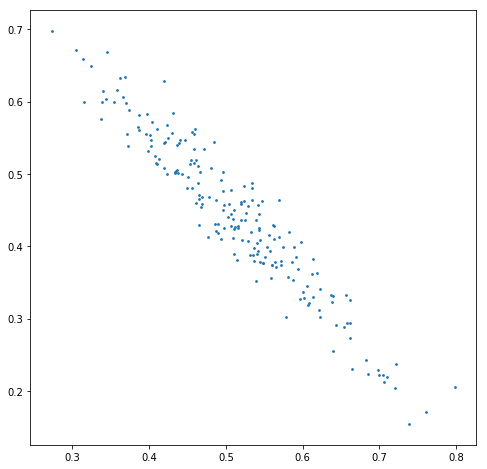

Optimal K: 20


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledData = scaler.fit_transform(data)
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(rescaledData)
plt.scatter(W[:,0],W[:,1], s=cluster_point_size)
optK = optimalK(W, cluster_array=cluster_arr, n_refs=3)
plt.show()
print("Optimal K: {}".format(optK))